In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as RectPatch

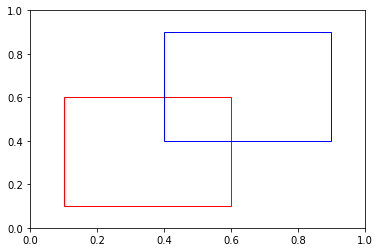

In [2]:
class Rectangle:
    def __init__(self, x0, x1, y0, y1):
        self.lower = np.array([x0, y0])
        self.higher = np.array([x1, y1])
        
    def inside(self, x, y):
        point = np.array([x, y])
        return ((self.lower <= point) * (point <= self.higher)).sum().item() == 2
    
    def plot(self, ax, edgecolor = 'blue'):
        dim = self.higher - self.lower
        ax.add_patch(RectPatch((self.lower[0], self.lower[1]), dim[0], dim[1], fill = False, edgecolor = edgecolor))
    
rect0 = Rectangle(0.1, 0.6, 0.1, 0.6)
rect1 = Rectangle(0.4, 0.9, 0.4, 0.9)

def draw_rectangles(ax, rect0, rect1):
    plt.axis([0., 1., 0., 1.])
    rect0.plot(ax, 'red')
    rect1.plot(ax)

fig, ax = plt.subplots()
draw_rectangles(ax, rect0, rect1)
plt.show()

In [115]:
class RectanglesDataset(Dataset):
    def __init__(self, count, r0, r1):
        super(RectanglesDataset, self).__init__()
        self.r0 = r0
        self.r1 = r1

        self.values = [torch.rand((2,)) for i in range(count)]
        self.labels = [self.correct(x, y) for (x, y) in self.values]

    def correct(self, x, y):
        small = self.r0.inside(x, y)
        big = small or self.r1.inside(x, y)
        return torch.tensor([1. if v else 0. for v in [small, big]])

    def __len__(self):
        return len(self.values)  

    def __getitem__(self, index):
        return self.values[index], self.labels[index]

In [133]:
points = 10000
train_data = RectanglesDataset(points, rect0, rect1)
test_data = RectanglesDataset(points // 10, rect0, rect1)

train_dataloader = DataLoader(train_data, batch_size = 64)
test_dataloader = DataLoader(test_data, batch_size = 64)

In [119]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(2, 4),
            nn.Tanh(),
            nn.Linear(4, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        return x

base = NeuralNetwork()
print(base)

NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): Sigmoid()
  )
)


### The CCN framework

In [120]:
class Literal:
    def __init__(self, *args):
        if len(args) == 2:
            # Literal(int, bool)
            self.atom = args[0]
            self.positive = args[1]
        else:
            # Literal(string)
            plain = args[0]
            if 'n' in plain:
                self.atom = int(plain[1:])
                self.positive = False
            else:
                self.atom = int(plain)
                self.positive = True
            
    def neg(self):
        return Literal(self.atom, not self.positive)
    
    def __str__(self):
        return str(self.atom) if self.positive else 'n' + str(self.atom)
    
for lit in [Literal('13'), Literal('n12'), Literal(17, True), Literal(19, False)]:
    print(str(lit))
    print(str(lit.neg()))

13
n13
n12
12
17
n17
n19
19


In [121]:
class Constraint:
    def __init__(self, *args):
        if len(args) == 2:
            # Constraint(Literal, [Literal])
            self.head = args[0]
            self.body = args[1]
        else:
            # Constraint(string)
            line = args[0].split(' ')
            if line[2] == ':-':
                line = line[1:]
            assert line[1] == ':-'
            self.head = Literal(line[0])
            self.body = [Literal(lit) for lit in line[2:]]
            
    def head_encoded(self, num_classes):
        pos_head = np.zeros(num_classes)
        neg_head = np.zeros(num_classes)
        if self.head.positive:
            pos_head[self.head.atom] = 1
        else:
            neg_head[self.head.atom] = 1
        return pos_head, neg_head
    
    def body_encoded(self, num_classes):
        pos_body = np.zeros(num_classes, dtype=int)
        neg_body = np.zeros(num_classes, dtype=int)
        for lit in self.body:
            if lit.positive:
                pos_body[lit.atom] = 1
            else:
                neg_body[lit.atom] = 1
        return pos_body, neg_body
    
    def where(self, cond, opt1, opt2):
        return opt2 + cond * (opt1 - opt2)
    
    def coherent_with(self, preds):
        num_classes = preds.shape[1]
        pos_body, neg_body = self.body_encoded(num_classes)
        pos_body = preds[:, pos_body.astype(bool)]
        neg_body = 1 - preds[:, neg_body.astype(bool)]
        body = np.min(np.concatenate((pos_body, neg_body), axis=1), axis=1)
        
        head = preds[:, self.head.atom]
        if not self.head.positive:
            head = 1 - head
            
        return body <= head
        
    def __str__(self):
        return str(self.head) + " :- " + ' '.join([str(lit) for lit in self.body])
    
    
cons0 = Constraint(Literal('1'), [Literal('0')])
cons1 = Constraint('0 :- 1 n2')
cons2 = Constraint('n0 :- n1 2 3')
    
for cons in [cons0, cons1, cons2]:
    print(cons)

assert (cons0.coherent_with(np.array([
    [0.1, 0.2],
    [0.2, 0.1],
    [0.1, 0.1]
])) == [True, False, True]).all()

assert (cons2.coherent_with(np.array([
    [0.7, 0.8, 0.3, 0.4],
    [0.8, 0.8, 0.3, 0.4],
    [0.9, 0.8, 0.3, 0.4],
])) == [True, True, False]).all()



1 :- 0
0 :- 1 n2
n0 :- n1 2 3


In [122]:
class ConstraintsGroup:
    def __init__(self, arg):
        if isinstance(arg, list):
            # ConstraintGroup([Constraint])
            self.constraints = arg
        else:
            # ConstraintGroup(string)
            with open(arg, 'r') as f:
                self.constraints = [Constraint(line) for line in f]
                
    def strata(self):
        # TODO: Implement stratification
        return [self, self]
                
    def head_encoded(self, num_classes):
        pos_head = []
        neg_head = []
        
        for constraint in self.constraints:
            pos, neg = constraint.head_encoded(num_classes)
            pos_head.append(pos)
            neg_head.append(neg)
            
        return np.array(pos_head), np.array(neg_head)
    
    def body_encoded(self, num_classes):
        pos_body = []
        neg_body = []
        
        for constraint in self.constraints:
            pos, neg = constraint.body_encoded(num_classes)
            pos_body.append(pos)
            neg_body.append(neg)
            
        return np.array(pos_body), np.array(neg_body)
            
    def encoded(self, num_classes):
        head = self.head_encoded(num_classes)
        body = self.body_encoded(num_classes)
        return head, body
    
    def coherent_with(self, preds):
        coherent = [constraint.coherent_with(preds) for constraint in self.constraints]
        return np.array(coherent).transpose()
            
    def __str__(self):
        return '\n'.join([str(constraint) for constraint in self.constraints])
        
constraints_group = ConstraintsGroup([cons0, cons1, cons2])
print(constraints_group)
#print(ConstraintGroup('/Users/home/Desktop/PyToys/constraint'))

assert (constraints_group.coherent_with(np.array([
    [0.1, 0.2, 0.3, 0.4],
    [0.7, 0.2, 0.3, 0.4],
    [0.8, 0.2, 0.3, 0.4]
])) == np.array([
     [ True, False,  True],
     [False,  True,  True],
     [False,  True, False]])).all()

1 :- 0
0 :- 1 n2
n0 :- n1 2 3


In [180]:
class ConstraintsModule(nn.Module):
    def __init__(self, constraints_group, num_classes):
        super(ConstraintsModule, self).__init__()
        head, body = constraints_group.encoded(num_classes)
        pos_head, neg_head = head
        pos_body, neg_body = body
        
        self.pos_head = torch.from_numpy(pos_head)
        self.neg_head = torch.from_numpy(neg_head)
        self.pos_body = torch.from_numpy(pos_body)
        self.neg_body = torch.from_numpy(neg_body)
        
    def where(self, cond, opt1, opt2):
        return opt2 + cond * (opt1 - opt2)
        
    def forward(self, preds):
        batch, num = preds.shape[0], preds.shape[1]
        cons = self.pos_head.shape[0]
        
        # batch x cons x num
        exp_preds = preds.unsqueeze(1).expand(batch, cons, num)
        pos_body = self.pos_body.unsqueeze(0).expand(batch, cons, num)
        neg_body = self.neg_body.unsqueeze(0).expand(batch, cons, num)
        
        # batch x cons
        pos_body_min = torch.min(self.where(pos_body, exp_preds, 1), dim=2).values
        neg_body_min = torch.min(self.where(neg_body, 1. - exp_preds, 1), dim=2).values
        body_min = torch.minimum(pos_body_min, neg_body_min)
        
        # batch x cons x num
        body_min = body_min.unsqueeze(2).expand(batch, cons, num)
        pos_head = self.pos_head.unsqueeze(0).expand(batch, cons, num)
        neg_head = self.neg_head.unsqueeze(0).expand(batch, cons, num)
        
        # batch x num
        pos_head_max = torch.max(body_min * pos_head, dim=1).values.float()
        neg_head_max = torch.max(body_min * neg_head, dim=1).values.float()
        preds = torch.maximum(pos_head_max, torch.minimum(1 - neg_head_max, preds.squeeze()))
        return preds
        
constraints_group = ConstraintsGroup([
    Constraint('1 :- 0'),
    Constraint('2 :- n3 4'),
    Constraint('n5 :- 6 n7 8'),
    Constraint('2 :- 9 n10'),
    Constraint('n5 :- 11 n12 n13'),
])

cm = ConstraintsModule(constraints_group, 14)
print(cm)
preds = torch.rand((1000, 14))
updated = cm(preds)
assert constraints_group.coherent_with(updated.numpy()).all()

ConstraintsModule()


In [201]:
class ConstraintsLayer(nn.Module):
    def __init__(self, constraints_group, num_classes):
        super(ConstraintsLayer, self).__init__()
        strata = constraints_group.strata()
        modules = [ConstraintsModule(stratum, num_classes) for stratum in strata]
        self.module_list = nn.ModuleList(modules)
        self.active = True
        
    def enable(self):
        self.active = True
        
    def disable(self):
        self.active = False
        
    def is_active(self):
        return self.active
        
    def forward(self, x):
        if self.active:
            for module in self.module_list:
                x = module(x)
        return x
    
constraints_layer = ConstraintsLayer(constraints_group, 14)
print(constraints_layer)
pred = torch.rand(1000, 14)
updated = constraints_layer(pred)
assert constraints_group.coherent_with(updated.numpy()).all()

ConstraintsLayer(
  (module_list): ModuleList(
    (0): ConstraintsModule()
    (1): ConstraintsModule()
  )
)


In [202]:
class ConstrainedNetwork(nn.Module):
    def __init__(self, base, constraints, num_classes):
        super(ConstrainedNetwork, self).__init__()
        self.base = base
        self.constraints = ConstraintsLayer(constraints, num_classes) 
        
    def enable_constraints(self):
        self.constraints.enable()
        
    def disable_constraints(self):
        self.constraints.disable()
        
    def constraints_active(self):
        return self.constraints.is_active()
        
    def forward(self, x):
        preds = self.base(x)
        preds = self.constraints(preds)
        return preds
    
model = ConstrainedNetwork(base, ConstraintsGroup([cons0]), 2)
print(model)

ConstrainedNetwork(
  (base): NeuralNetwork(
    (linear): Sequential(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): Tanh()
      (2): Linear(in_features=4, out_features=2, bias=True)
      (3): Sigmoid()
    )
  )
  (constraints): ConstraintsLayer(
    (module_list): ModuleList(
      (0): ConstraintsModule()
      (1): ConstraintsModule()
    )
  )
)


### Training and testing

In [203]:
loss_fn = nn.BCELoss()
learning_rate = 1e-2
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.9, 0.999))

In [204]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):   
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [205]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct_small, correct_big = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct_small += (torch.where(pred[:, 0] > 0.5, 1., 0.) == y[:, 0]).sum().item()
            correct_big += (torch.where(pred[:, 1] > 0.5, 1., 0.) == y[:, 1]).sum().item()
    test_loss /= size
    correct_small /= size
    correct_big /= size
    print(f"Test Error: \n Accuracy: {(100*correct_small):>0.1f}%, {(100*correct_big):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Training and testing on the Rectangles dataset

In [211]:
epochs = 300
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 0.282106 [    0/10000]
loss: 0.154154 [ 6400/10000]
Test Error: 
 Accuracy: 95.2%, 85.3%, Avg loss: 0.003057 

Epoch 2
-------------------------------
loss: 0.281498 [    0/10000]
loss: 0.154038 [ 6400/10000]
Test Error: 
 Accuracy: 95.2%, 85.3%, Avg loss: 0.003055 

Epoch 3
-------------------------------
loss: 0.281355 [    0/10000]
loss: 0.153919 [ 6400/10000]
Test Error: 
 Accuracy: 95.2%, 85.3%, Avg loss: 0.003054 

Epoch 4
-------------------------------
loss: 0.281215 [    0/10000]
loss: 0.153799 [ 6400/10000]
Test Error: 
 Accuracy: 95.2%, 85.3%, Avg loss: 0.003052 

Epoch 5
-------------------------------
loss: 0.281071 [    0/10000]
loss: 0.153721 [ 6400/10000]
Test Error: 
 Accuracy: 95.2%, 85.2%, Avg loss: 0.003050 

Epoch 6
-------------------------------
loss: 0.280933 [    0/10000]
loss: 0.153587 [ 6400/10000]
Test Error: 
 Accuracy: 95.2%, 85.2%, Avg loss: 0.003048 

Epoch 7
-------------------------------
loss: 0.280750 [  

loss: 0.141203 [ 6400/10000]
Test Error: 
 Accuracy: 95.8%, 86.1%, Avg loss: 0.002758 

Epoch 54
-------------------------------
loss: 0.241179 [    0/10000]
loss: 0.140823 [ 6400/10000]
Test Error: 
 Accuracy: 95.8%, 86.0%, Avg loss: 0.002742 

Epoch 55
-------------------------------
loss: 0.239770 [    0/10000]
loss: 0.140452 [ 6400/10000]
Test Error: 
 Accuracy: 95.7%, 86.0%, Avg loss: 0.002726 

Epoch 56
-------------------------------
loss: 0.238374 [    0/10000]
loss: 0.140109 [ 6400/10000]
Test Error: 
 Accuracy: 95.7%, 86.2%, Avg loss: 0.002709 

Epoch 57
-------------------------------
loss: 0.237162 [    0/10000]
loss: 0.139675 [ 6400/10000]
Test Error: 
 Accuracy: 95.7%, 86.3%, Avg loss: 0.002693 

Epoch 58
-------------------------------
loss: 0.235679 [    0/10000]
loss: 0.139291 [ 6400/10000]
Test Error: 
 Accuracy: 95.7%, 86.6%, Avg loss: 0.002676 

Epoch 59
-------------------------------
loss: 0.234325 [    0/10000]
loss: 0.138965 [ 6400/10000]
Test Error: 
 Accuracy:

loss: 0.112739 [ 6400/10000]
Test Error: 
 Accuracy: 96.8%, 94.2%, Avg loss: 0.002080 

Epoch 106
-------------------------------
loss: 0.186643 [    0/10000]
loss: 0.112190 [ 6400/10000]
Test Error: 
 Accuracy: 96.8%, 94.2%, Avg loss: 0.002073 

Epoch 107
-------------------------------
loss: 0.186027 [    0/10000]
loss: 0.111536 [ 6400/10000]
Test Error: 
 Accuracy: 96.8%, 94.2%, Avg loss: 0.002065 

Epoch 108
-------------------------------
loss: 0.185403 [    0/10000]
loss: 0.110895 [ 6400/10000]
Test Error: 
 Accuracy: 96.8%, 94.1%, Avg loss: 0.002058 

Epoch 109
-------------------------------
loss: 0.184792 [    0/10000]
loss: 0.110266 [ 6400/10000]
Test Error: 
 Accuracy: 96.9%, 94.3%, Avg loss: 0.002051 

Epoch 110
-------------------------------
loss: 0.184193 [    0/10000]
loss: 0.109649 [ 6400/10000]
Test Error: 
 Accuracy: 96.9%, 94.4%, Avg loss: 0.002044 

Epoch 111
-------------------------------
loss: 0.183832 [    0/10000]
loss: 0.109069 [ 6400/10000]
Test Error: 
 Acc

loss: 0.093527 [ 6400/10000]
Test Error: 
 Accuracy: 96.9%, 94.6%, Avg loss: 0.001818 

Epoch 158
-------------------------------
loss: 0.167793 [    0/10000]
loss: 0.093320 [ 6400/10000]
Test Error: 
 Accuracy: 96.9%, 94.7%, Avg loss: 0.001814 

Epoch 159
-------------------------------
loss: 0.167541 [    0/10000]
loss: 0.093340 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.7%, Avg loss: 0.001811 

Epoch 160
-------------------------------
loss: 0.167418 [    0/10000]
loss: 0.093197 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.8%, Avg loss: 0.001808 

Epoch 161
-------------------------------
loss: 0.167214 [    0/10000]
loss: 0.093008 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.8%, Avg loss: 0.001804 

Epoch 162
-------------------------------
loss: 0.166989 [    0/10000]
loss: 0.092842 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.8%, Avg loss: 0.001801 

Epoch 163
-------------------------------
loss: 0.166781 [    0/10000]
loss: 0.092680 [ 6400/10000]
Test Error: 
 Acc

loss: 0.087125 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001685 

Epoch 210
-------------------------------
loss: 0.158931 [    0/10000]
loss: 0.087044 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001684 

Epoch 211
-------------------------------
loss: 0.158836 [    0/10000]
loss: 0.086964 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001682 

Epoch 212
-------------------------------
loss: 0.158769 [    0/10000]
loss: 0.086878 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001680 

Epoch 213
-------------------------------
loss: 0.158664 [    0/10000]
loss: 0.086796 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001678 

Epoch 214
-------------------------------
loss: 0.158513 [    0/10000]
loss: 0.086705 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001676 

Epoch 215
-------------------------------
loss: 0.158415 [    0/10000]
loss: 0.086627 [ 6400/10000]
Test Error: 
 Acc

loss: 0.083751 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001608 

Epoch 262
-------------------------------
loss: 0.155538 [    0/10000]
loss: 0.083689 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001607 

Epoch 263
-------------------------------
loss: 0.155476 [    0/10000]
loss: 0.083643 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001606 

Epoch 264
-------------------------------
loss: 0.155423 [    0/10000]
loss: 0.083598 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001604 

Epoch 265
-------------------------------
loss: 0.155373 [    0/10000]
loss: 0.083553 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001603 

Epoch 266
-------------------------------
loss: 0.155323 [    0/10000]
loss: 0.083508 [ 6400/10000]
Test Error: 
 Accuracy: 97.0%, 94.9%, Avg loss: 0.001602 

Epoch 267
-------------------------------
loss: 0.155273 [    0/10000]
loss: 0.083464 [ 6400/10000]
Test Error: 
 Acc

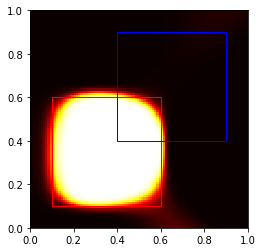

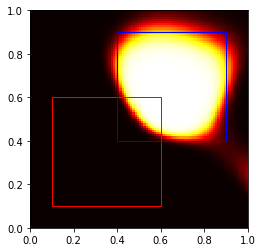

In [215]:
xs = np.arange(0., 1., 0.01, dtype = "float32")
ys = np.arange(0., 1., 0.01, dtype = "float32")
grid = np.array([(x, y) for x in xs for y in ys])
grid = torch.from_numpy(grid)

model.disable_constraints()
probs = model(grid)
model.enable_constraints()

small = probs[:, 0].reshape(len(xs), len(ys)).detach().numpy()
large = probs[:, 1].reshape(len(xs), len(ys)).detach().numpy()

fig, ax = plt.subplots()
ax.imshow(small, cmap='hot', interpolation='nearest', extent=(0., 1., 0., 1.), origin='lower')
draw_rectangles(ax, rect0, rect1)
plt.show()

fig, ax = plt.subplots()
ax.imshow(large, cmap='hot', interpolation='nearest', extent=(0., 1., 0., 1.), origin='lower')
draw_rectangles(ax, rect0, rect1)
plt.show()

In [213]:
print(small.max())
print(large.max())

1.0
0.9998578
